# Path To CSV Files
- path1 is to year of transactions
- path2 is to week of transactions

In [106]:
path1 = 'trans2017.csv'
path2 = 'last_week.csv'

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from re import sub
from decimal import Decimal
import datetime
from decimal import Decimal, ROUND_HALF_UP
from dateutil.parser import parse

In [108]:
#special dictionary to correspond numbers to days of week
days_key = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

#returns numeric version of cash value
def format_money(m):
    return Decimal(sub(r'[^\d.]', '', m))

#rounds decimal to two places for dollars
def round_decimal(x):
    return x.quantize(Decimal(".01"), rounding=ROUND_HALF_UP)

#output a dataframe that is easy to work with from transactions raw data
def process_transactions(path, category = 'Gross Sales', empl = None, show_td = False):
    #clean
    td = pd.read_csv(path, low_memory=False) #load
    td.insert(0, 'TimeStamp', (td['Date'] + ' ' + td['Time']).apply(lambda x: parse(x))) #datetime obj
    td = td[['TimeStamp', category]].copy() #use only relevant fields
    td.insert(1, 'Hour', td['TimeStamp'].apply(lambda x : x.hour)) #add column for hour of day (for later use saves comp time)
    td.insert(1, 'Day', td['TimeStamp'].apply(lambda x : x.weekday())) #add column for day of week (for later use saves comp time)
    td.insert(1, 'Date', td['TimeStamp'].apply(lambda x : x.date())) #add column for date (for later use saves comp time)
    td[category] = td[category].apply(lambda x : format_money(x)) #format sales at decimal
    td.drop(td[td[category] <= 0.00].index, inplace = True) #delete gross sales of 0.00 or less
    if show_td:
        display(td)
    
    #preparing results, day_average
    #times = td['Hour'].unique() #unique hours
    #times = times[(times>=6) & (times<=18)] #cut hours not between 6AM - 6PM
    #times.sort() #accending order
    #print('times',type(times))
    times = np.arange(6,19)
    days = td['Day'].unique() #unique days in data
    days.sort()
    res = pd.DataFrame(index = times, columns = days) #resulting dataframe with unique times & days
    res.index.name = 'HR' #label index
    day_averages = pd.DataFrame(index = ['Ave. {}'.format(category)], columns = days)
    '''
    if empl != None:
        workers = pd.DataFrame(index = times, columns = days)
    '''
    
    #populate results, day_averages
    for v in days:
        day = td[td['Day'] == v] #select all transactions on day, ie: Monday
        #day = td[td['TimeStamp'].apply(lambda x : x.weekday()) == v]
        num_day = day['Date'].unique().size #number of these days, ie: Number of Mondays
        gros_tot_day = day[category].sum() #total gross sales for day, ie: Total Gross of all Mondays
        day_ave = gros_tot_day / num_day #average gross sales for day ie: Average gross on Mondays
        day_averages[v] = round_decimal(day_ave) #populate another data frame with whole day averages
        for t in times:
            if t in day['Hour'].unique(): #some days have longer hours, check if this hour is in this day, ie: 5AM doesn't exist on Sundays
            #if t in day['TimeStamp'].apply(lambda x : x.hour).unique():
                day_hr_ave = day[day['Hour'] == t][category].sum() / num_day #Average sales on this hour on this day
                res[v][t] = round_decimal(day_hr_ave) #select day & hour in resulting frame and insert formated day_hr_ave
    
    res.fillna(0, inplace = True) #replace NaN with 0, these are likely times we aren't open
    res.columns = list(map(lambda x:days_key[x], res.columns))
    day_averages.columns = list(map(lambda x:days_key[x], day_averages.columns))
    rng = '{} to {}'.format(min(td['Date']), max(td['Date']))
    '''
    for v in list(td['Date'].unique()):
        #populate works dataframe with who was working each hour of each day of the week
    

    if empl != None:
        return res, workers, day_averages
    else:
        return res, day_averages
    '''
    return res, day_averages, rng, category

#plots the charts, given two processed transactions, a day, and a show frame parameter
def plot_sales(t, tsub, d, show_frames = False):
    
    if d not in t[0].columns:
        print('{} not in transactions'.format(d))
        return
    if d not in tsub[0].columns:
        print('{} not in sub-transactions'.format(d))
        return
    #parameters t
    n_groups_t = t[0].index.size #groups correspond to hours in transactions
    indecies_t = np.arange(n_groups_t) #indecies from 0 to the value of n_groups
    groups_t = t[0].index #list of hours in subset transactions
    
    #parameters tsub
    n_groups_tsub = tsub[0].index.size #groups correspond to hours in subset transactions
    indecies_tsub = np.arange(n_groups_tsub) #indecies from 0 to the value of n_groups
    groups_tsub = tsub[0].index #list of hours in subset transactions
    
    #parameters other
    bar_width = 0.45
    
    #Comparison of t & tsub
    fig1, ax1 = plt.subplots(figsize = (18, 6))
    plt.bar(indecies_t, t[0][d].values, bar_width, color='b', label = t[2])
    plt.bar(indecies_tsub + bar_width, tsub[0][d].values, bar_width, color='r', label=tsub[2])
    plt.xlabel('Hours (hr)', fontsize = 14)
    plt.ylabel('Average {} ($)'.format(t[3]), fontsize = 14)
    plt.title('Average {} by Hour: {}'.format(t[3], d), fontsize = 18)
    plt.xticks(indecies_t + bar_width/2, groups_t)
    for i, j in zip(indecies_t, t[0][d].values):
        ax1.text(i-(bar_width/2), j+2, '$' + str(j), color='b', fontweight='bold')
    for i, j in zip(indecies_tsub, tsub[0][d].values):
        ax1.text(i + (bar_width/2), j+2, '$' + str(j), color='r', fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #Difference between t & tsub
    #parameters
    bar_width *= 0.5
    
    fig2, ax2 = plt.subplots(figsize = (18,6))
    dif = tsub[0][d] - t[0][d]
    dif_pos = dif.values.copy() 
    dif_pos[dif_pos<0] = 0
    dif_neg = dif.values.copy()
    dif_neg[dif_neg>0] = 0
    plt.bar(indecies_t, dif_pos, bar_width, color='g')
    for i, j, v in zip(indecies_t, dif_pos, t[0][d].values):
        if (j != 0):
            ax2.text(i-(bar_width/2), j+3, '$' + str(j), color='g', fontweight='bold')
    plt.bar(indecies_t, dif_neg, bar_width, color='r')
    for i, j, v in zip(indecies_t, dif_neg, t[0][d].values):
        if (j != 0):
            ax2.text(i-(bar_width/2), j-3, '$' + str(j), color='r', fontweight='bold')
            #ax2.text(i-(bar_width/2), j-3, str(round_decimal(100*j/v)) + ' %', color='r', fontweight='bold')
    plt.xlabel('Hours (hr)', fontsize = 14)
    plt.ylabel('Average {} ($)'.format(t[3]), fontsize = 14)
    plt.title('Difference Average {} by Hour: {}'.format(t[3], d), fontsize = 18)
    plt.xticks(indecies_t, groups_t)
    plt.grid(True)
    plt.show()
    
    if show_frames:
        #Data Frames
        print(t[2])
        display(t[0])
        display(t[1])
        print(tsub[2])
        display(tsub[0])
        display(tsub[1])

# Charts
- Average Sales by Hour: Each hour is out of 24 and shows average sales from the two transaction files
- Difference Average Sales by Hour: Each hour shows how far off from the year average the given week was. 

^^^Same for tips

# Sales

2017-01-30 to 2017-12-31


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
HR,,,,,,,
6,50.84,63.96,61.12,61.47,62.40,0.62,0.07
7,130.50,137.34,153.05,153.65,166.23,38.76,7.19
8,110.53,120.30,123.79,121.94,139.98,73.83,44.00
9,101.14,102.09,105.84,102.81,103.69,77.80,67.21
10,84.69,92.95,94.34,92.08,106.96,85.95,77.98
11,47.38,59.26,44.75,46.85,56.89,66.30,60.89
12,50.13,54.60,53.38,54.01,52.09,53.73,42.32
13,41.41,44.11,43.27,43.77,55.44,38.72,32.33
14,32.31,40.16,36.71,37.31,37.53,37.26,23.09


2018-06-03 to 2018-06-09


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
HR,,,,,,,
6,76.53,74.92,70.90,77.66,86.15,0,0
7,166.87,226.11,198.96,181.58,245.19,89.16,25.34
8,132.01,181.78,160.32,228.01,194.99,99.59,94.11
9,125.53,101.11,141.80,144.87,83.98,87.75,99.84
10,120.45,68.32,113.65,86.39,105.82,55.40,92.16
11,54.16,79.18,38.57,59.39,73.86,82.63,68.85
12,52.46,72.61,64.73,83.05,46.59,68.63,15.83
13,77.82,43.95,54.18,60.59,42.18,39.10,40.91
14,33.24,72.49,67.95,71.26,30.54,69.10,35.11


2017-01-30 to 2017-12-31


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Ave. Gross Sales,730.06,808.49,801.47,809.34,884.58,522.12,378.48


2018-06-03 to 2018-06-09


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Ave. Gross Sales,999.97,1052.82,1009.25,1150.55,1048.90,626.72,486.61


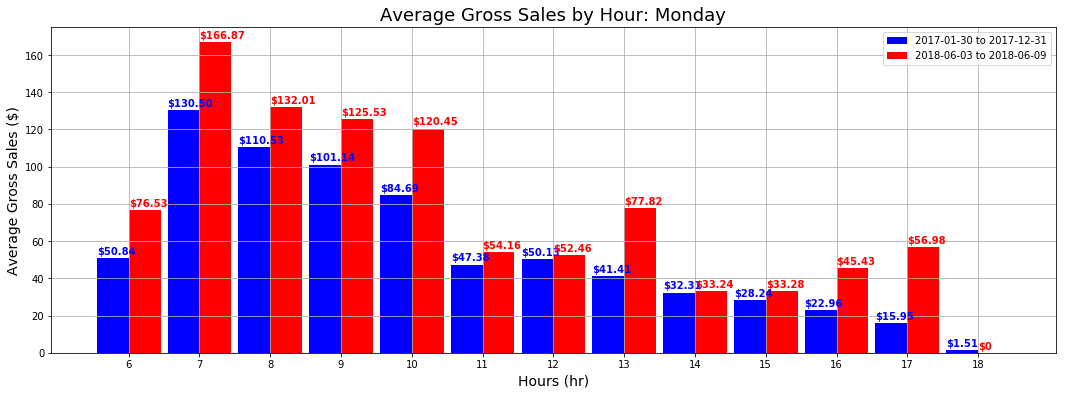

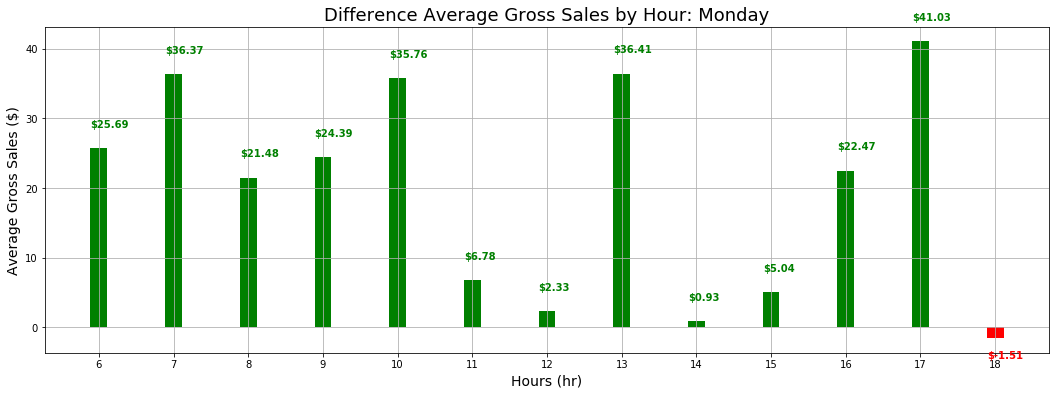

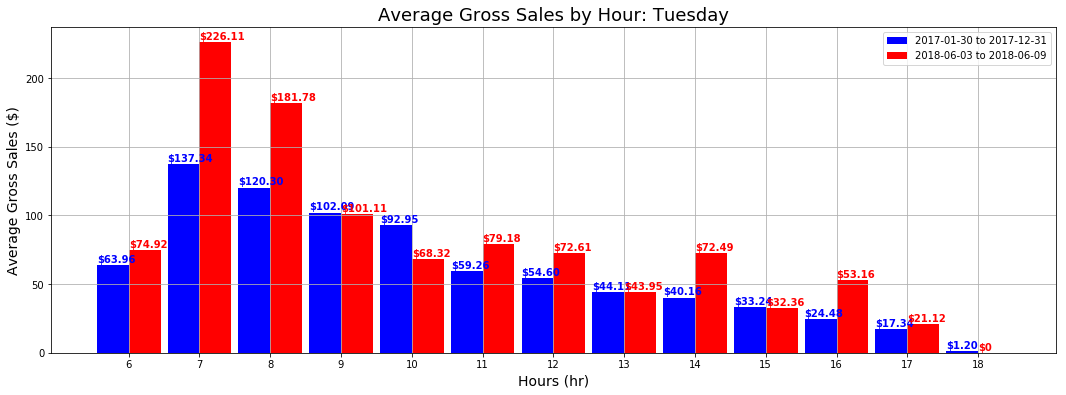

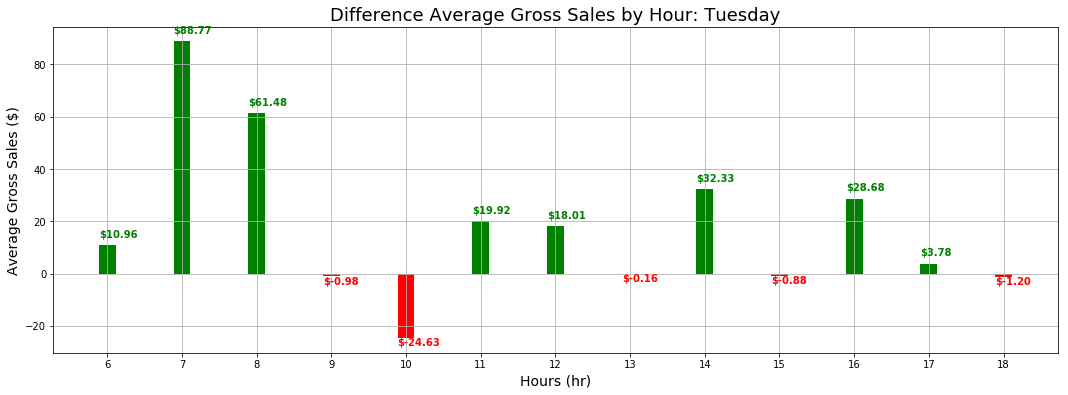

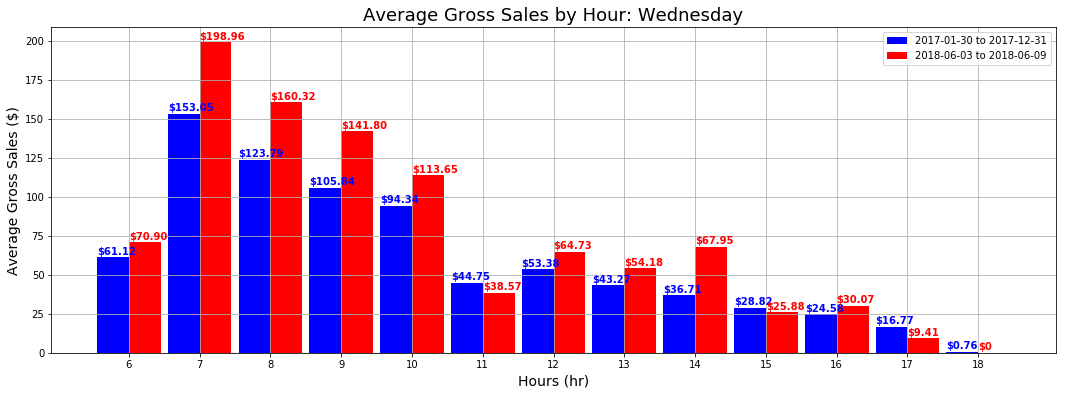

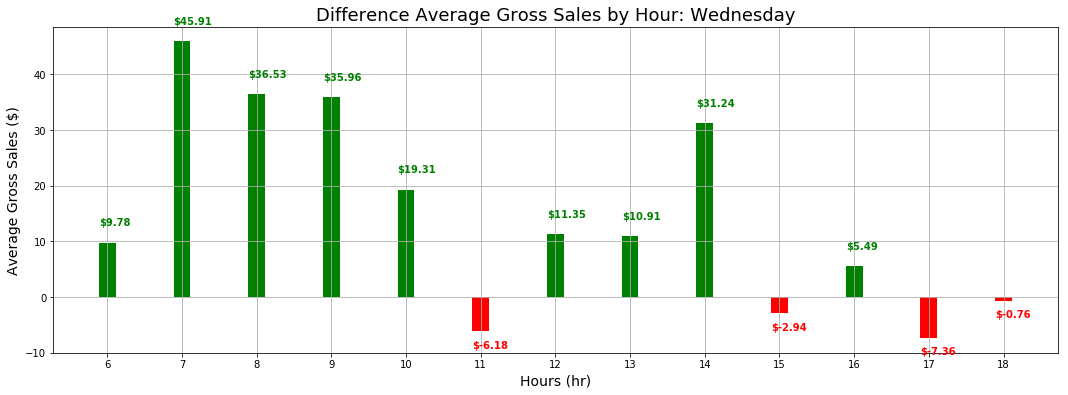

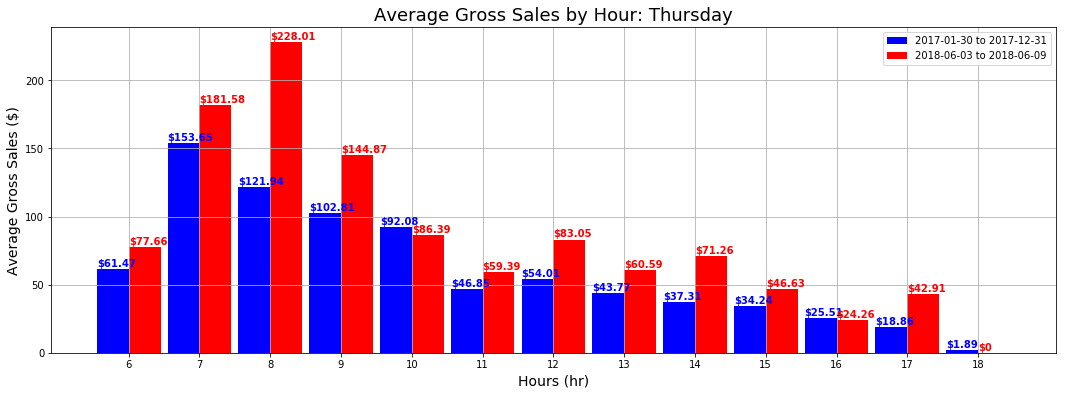

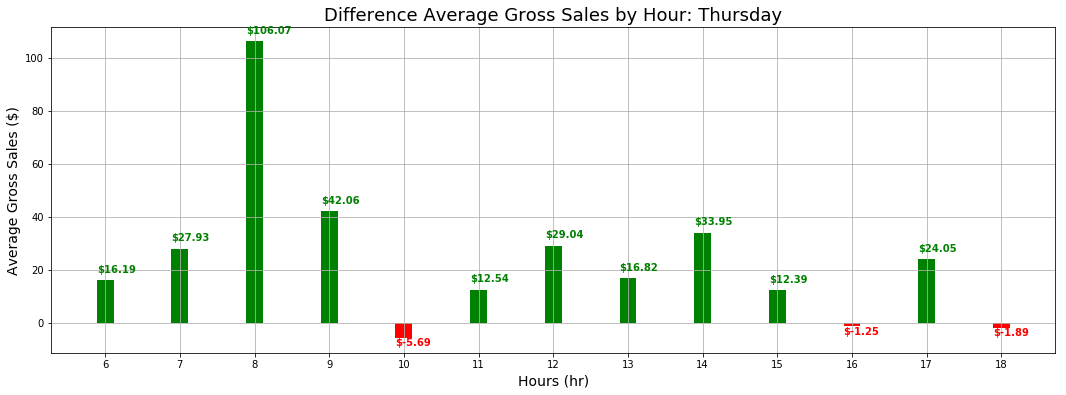

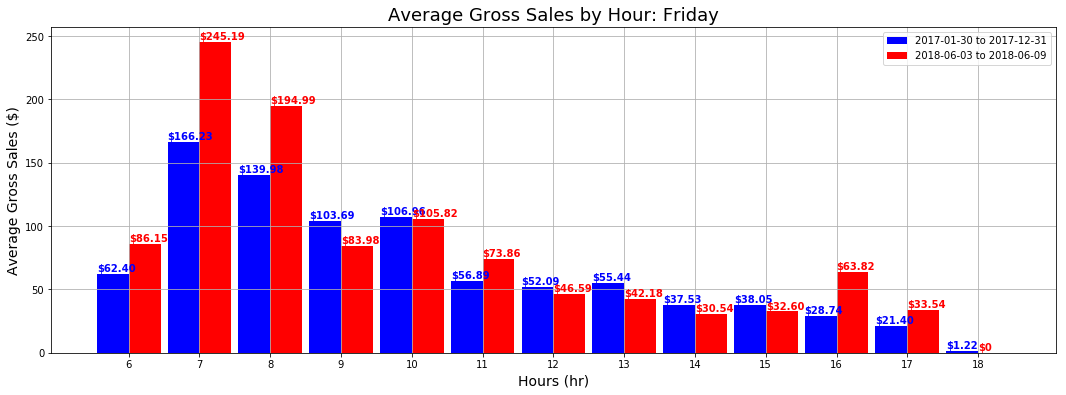

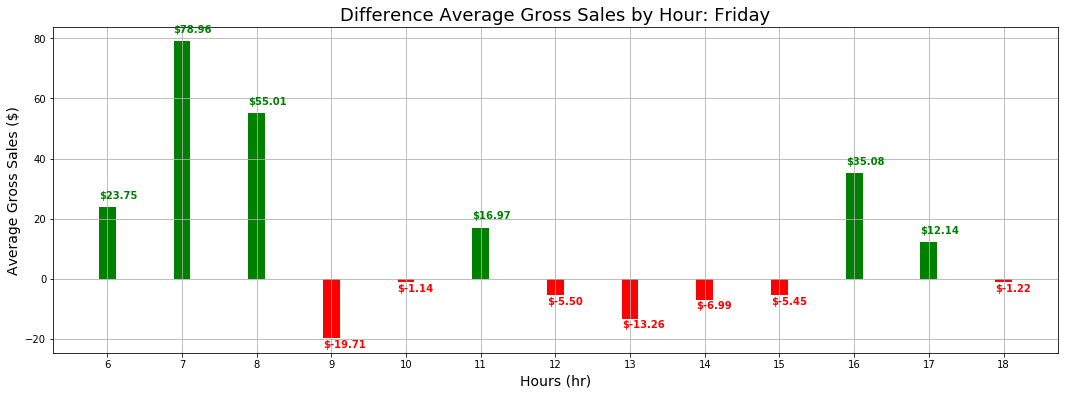

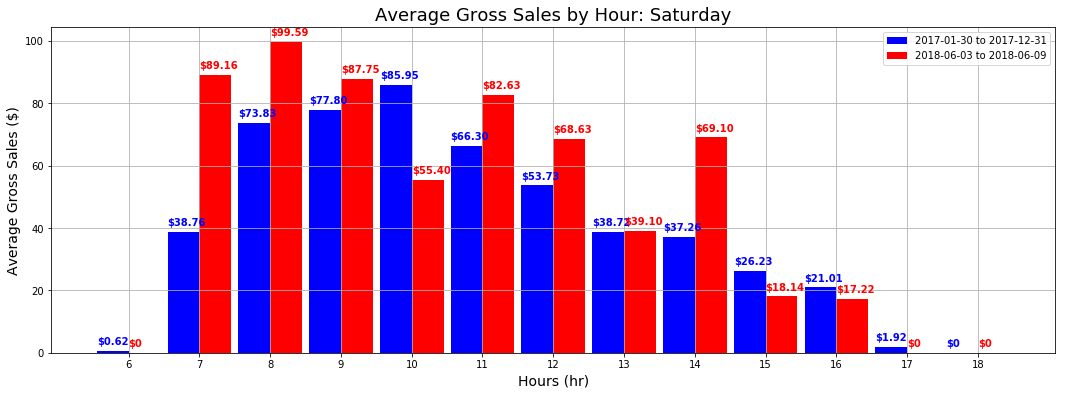

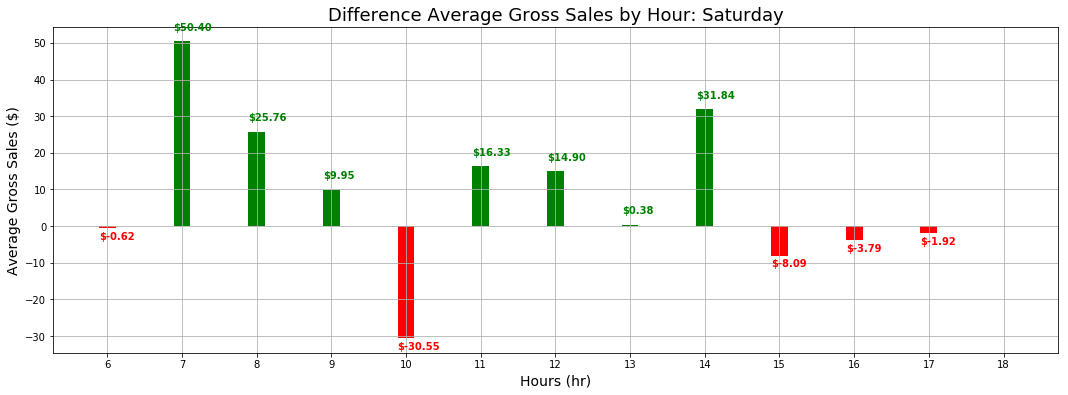

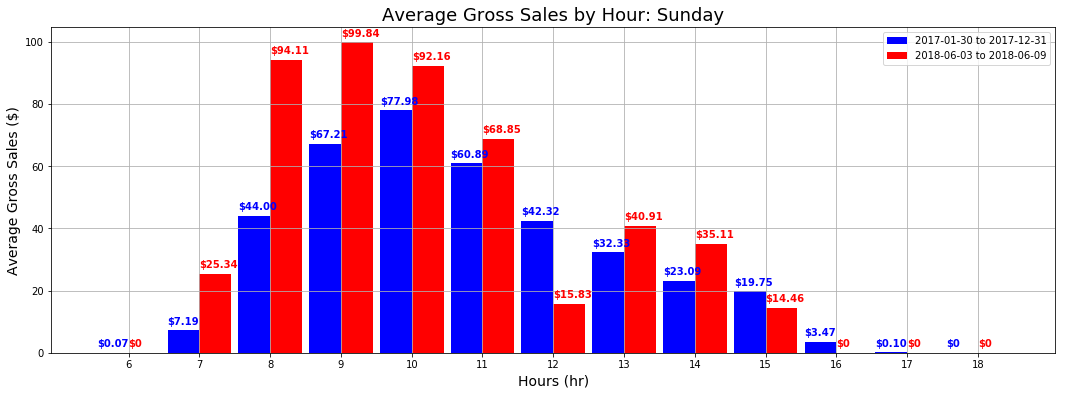

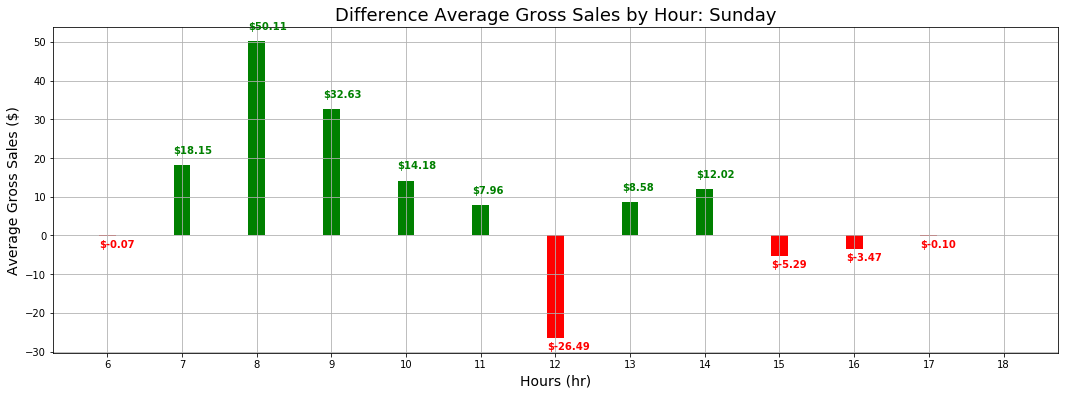

In [109]:
#process transactions
yr= process_transactions(path1)
wk= process_transactions(path2)

print(yr[2])
display(yr[0])
print(wk[2])
display(wk[0])

print(yr[2])
display(yr[1])
print(wk[2])
display(wk[1])

#run all 7 days of the week
for i,k in days_key.items():
    plot_sales(yr, wk, k) 

# Tips

2017-01-30 to 2017-12-31


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
HR,,,,,,,
6,5.55,6.80,7.83,7.76,7.91,0.02,0.02
7,12.73,13.99,16.61,16.12,17.69,4.83,1.22
8,12.19,14.58,13.82,14.23,15.17,9.24,5.05
9,9.08,9.98,11.52,10.31,10.99,8.82,7.59
10,7.39,8.10,8.44,8.15,9.78,9.15,7.64
11,5.07,5.98,4.26,4.76,5.70,7.83,6.93
12,5.12,6.20,6.08,5.62,5.89,5.07,4.45
13,4.32,4.83,4.91,5.44,5.93,4.52,3.13
14,3.31,3.42,3.86,3.65,3.43,3.77,2.34


2018-06-03 to 2018-06-09


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
HR,,,,,,,
6,3.00,7.00,9.50,7.00,8.50,0,0
7,15.00,28.92,21.01,22.00,27.26,14.60,4.10
8,11.00,16.65,17.40,20.59,24.05,14.40,11.25
9,10.56,11.50,7.30,16.65,9.00,5.50,4.84
10,10.25,9.50,8.00,8.75,10.50,2.00,12.25
11,6.00,9.58,4.00,4.00,12.00,17.80,12.60
12,3.00,4.25,5.00,13.45,6.15,13.20,0.50
13,9.50,5.00,6.96,9.84,6.00,0,5.50
14,1.75,3.75,6.78,3.00,1.00,8.00,5.00


2017-01-30 to 2017-12-31


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Ave. Tip,72.89,84.31,88.32,87.60,94.53,58.24,40.74


2018-06-03 to 2018-06-09


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Ave. Tip,79.26,112.31,102.95,121.28,122.23,80.50,59.04


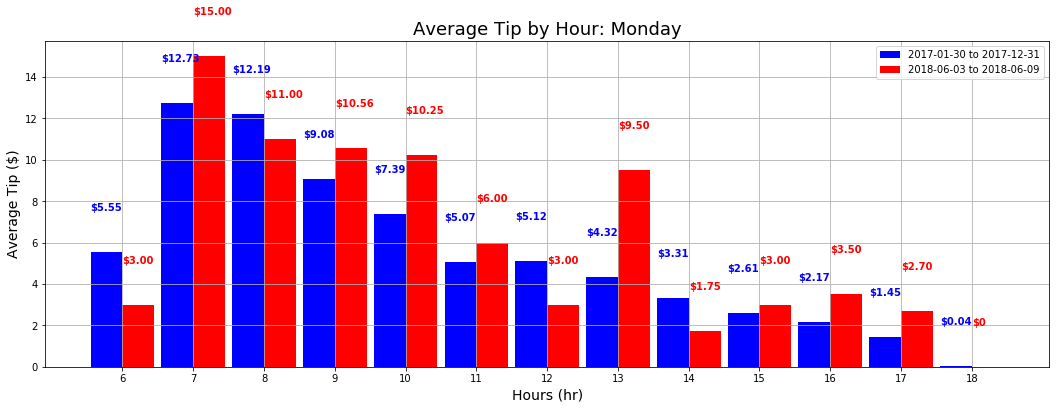

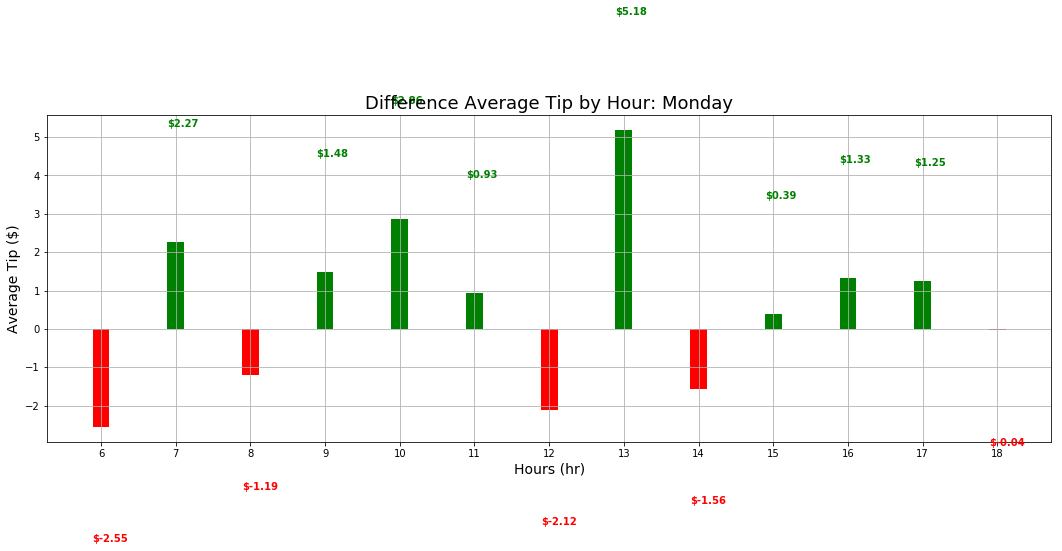

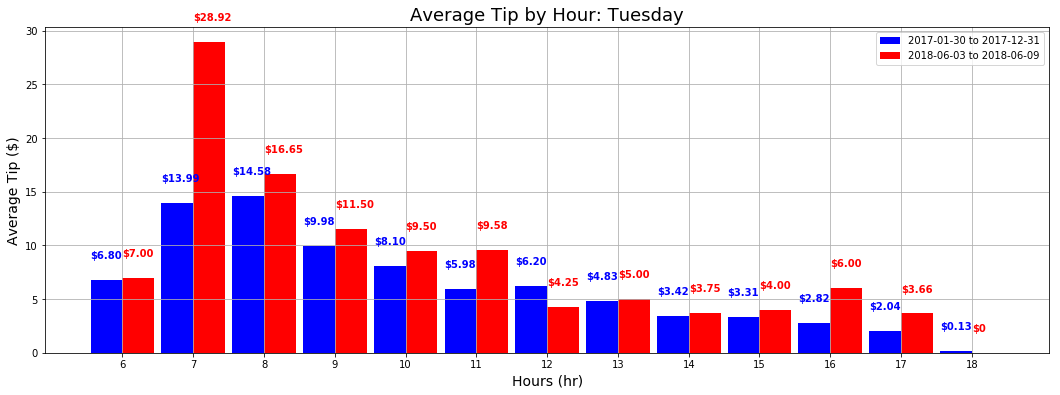

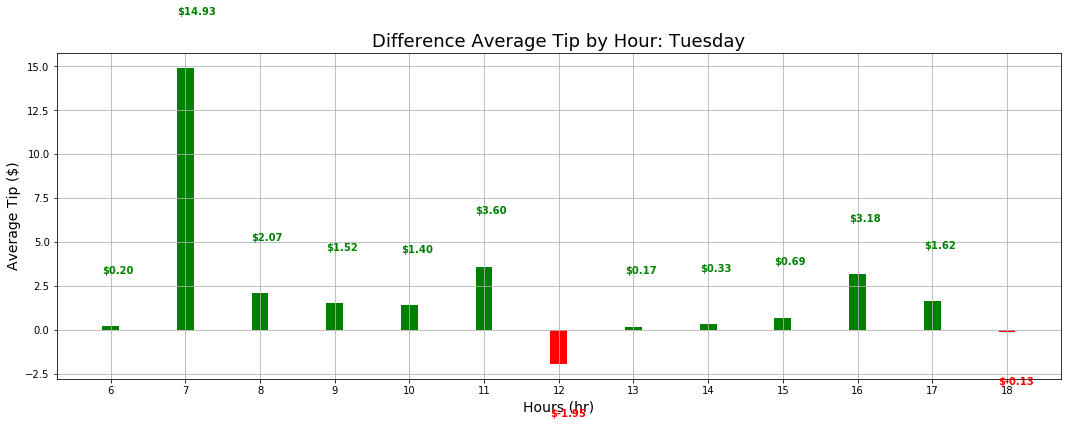

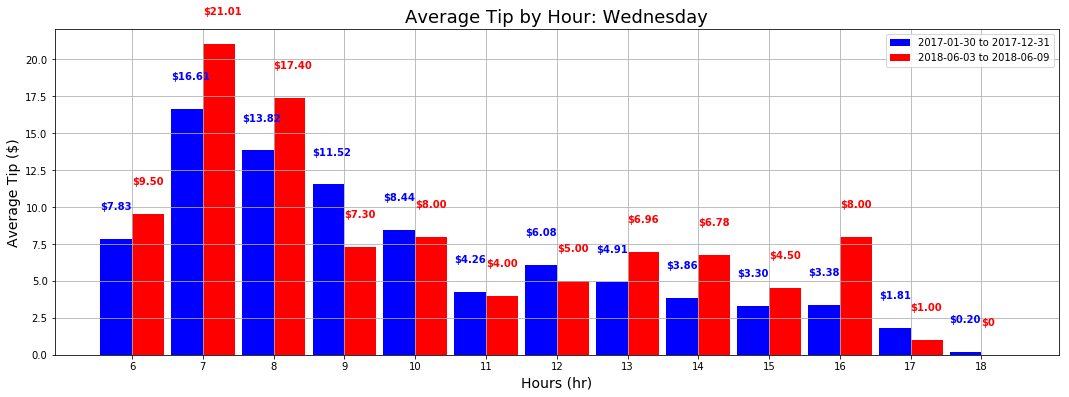

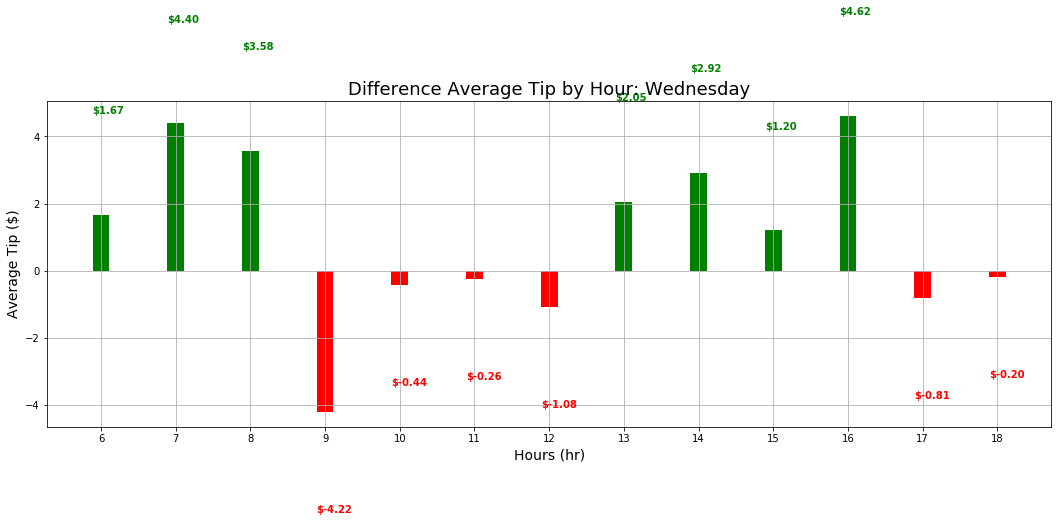

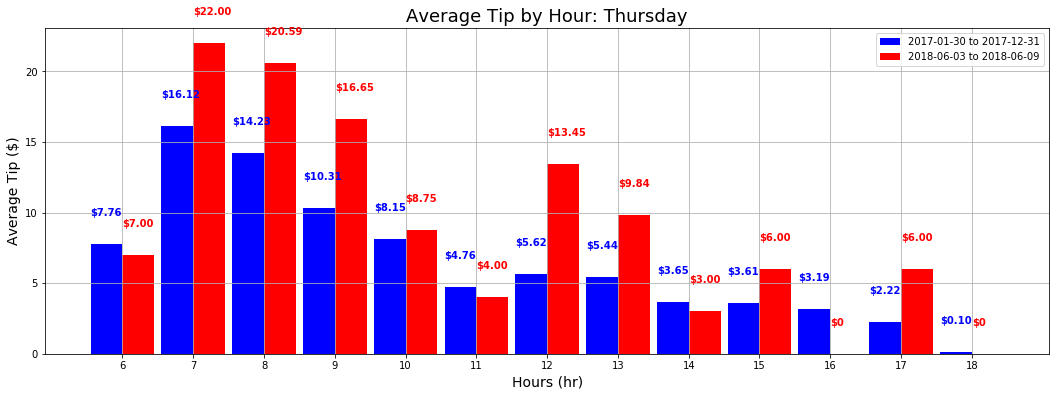

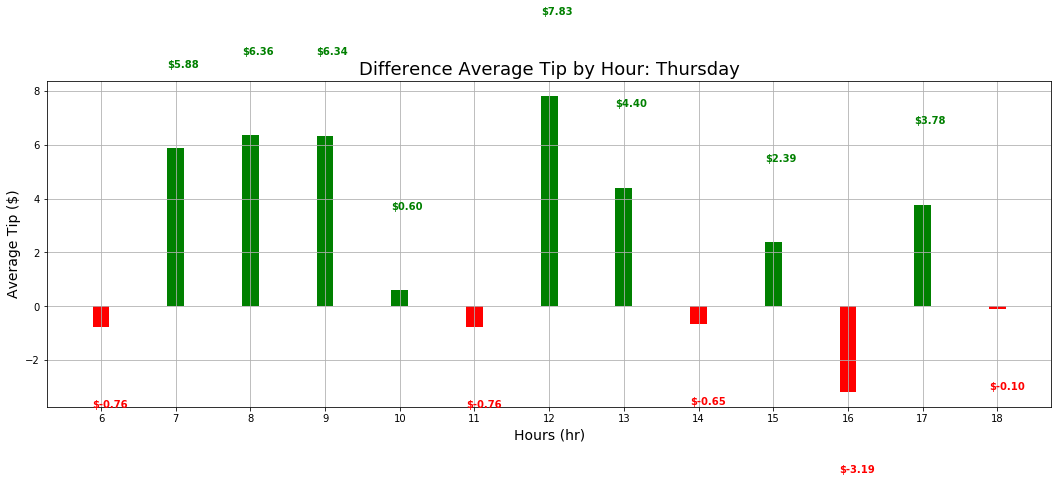

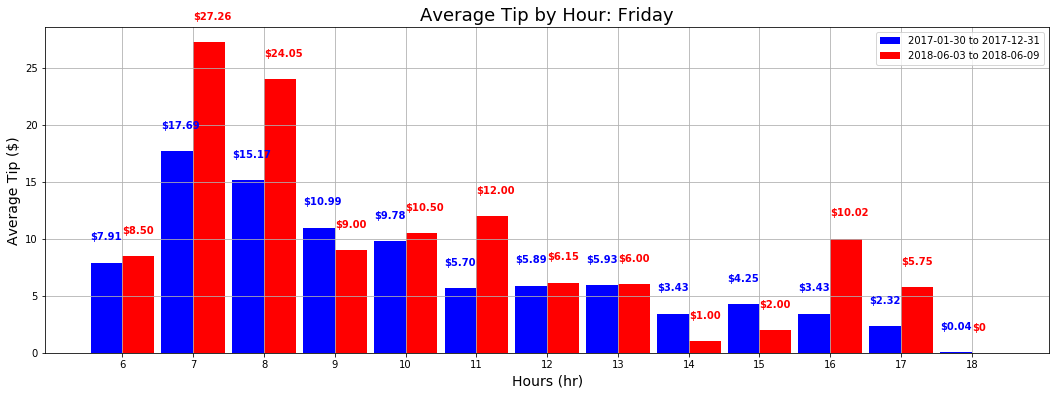

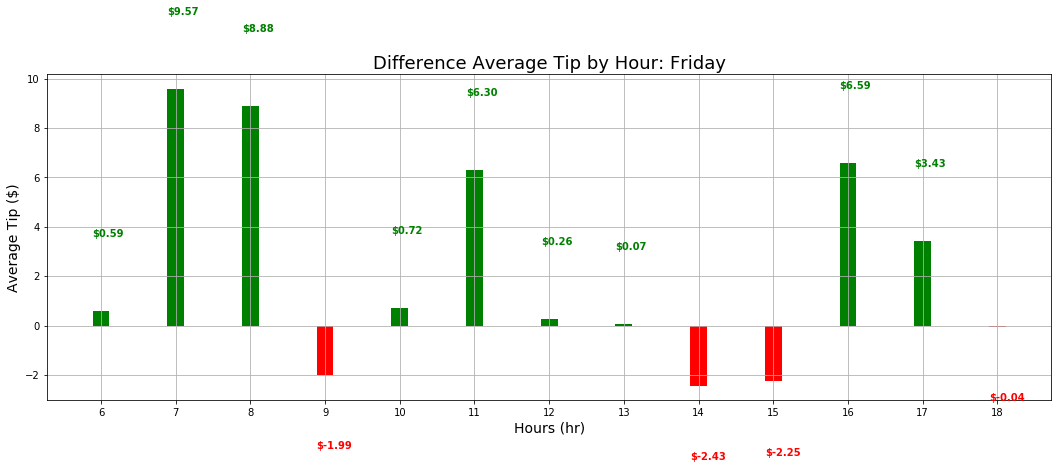

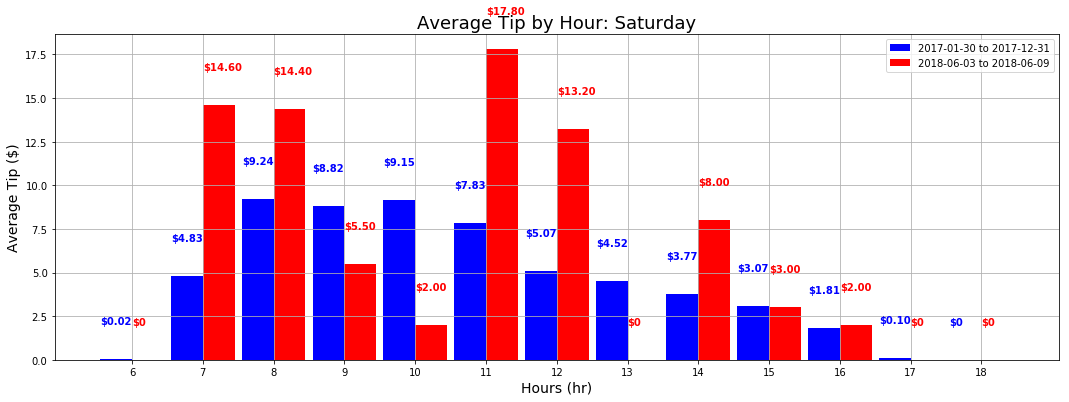

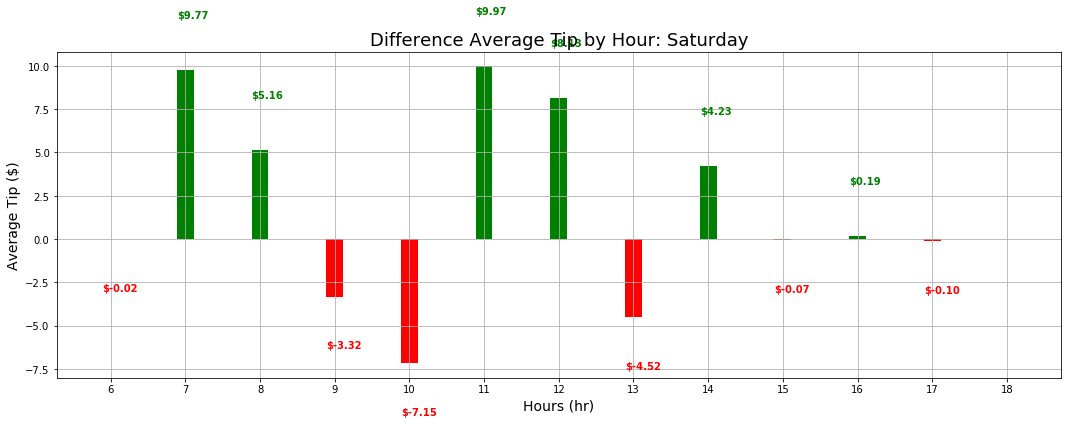

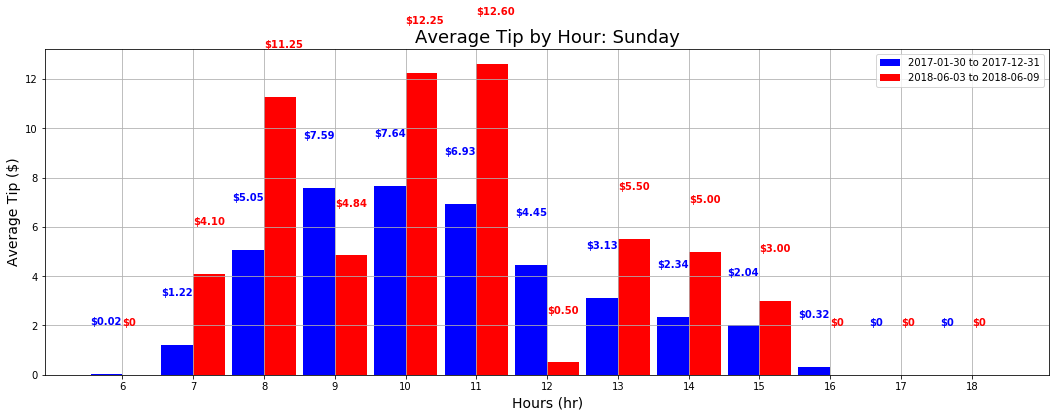

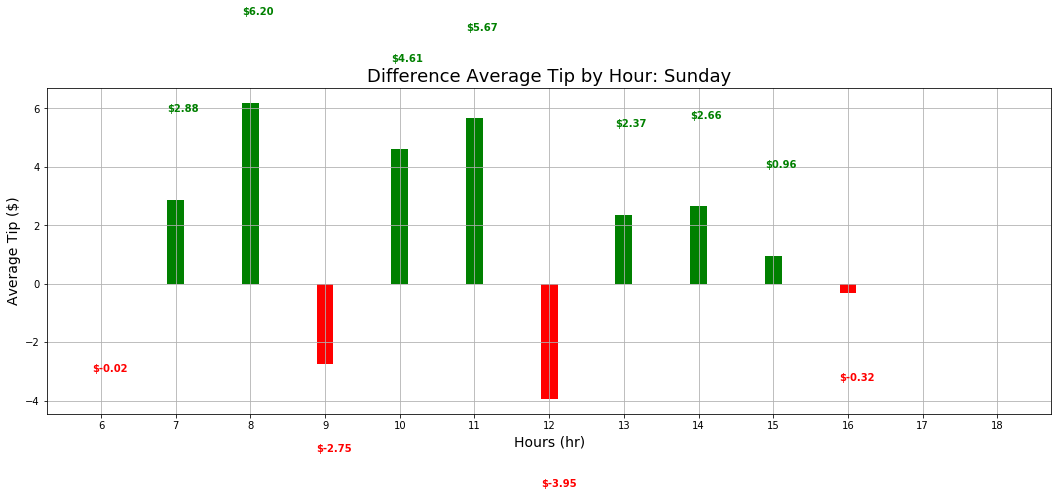

In [110]:
#process transactions
yr= process_transactions(path1, 'Tip')
wk= process_transactions(path2, 'Tip')

print(yr[2])
display(yr[0])
print(wk[2])
display(wk[0])

print(yr[2])
display(yr[1])
print(wk[2])
display(wk[1])

#run all 7 days of the week
for i,k in days_key.items():
    plot_sales(yr, wk, k) 